In [16]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import h5py
import matplotlib.animation as animation
from sklearn.linear_model import LinearRegression
from IPython.display import display, clear_output
import time

In [17]:

# Function to find the closest calibration image
def find_closest_calibration_image(scene_temp, calibration_data):
    calibration_temperatures = calibration_data['t_fpa'].values
    closest_index = (np.abs(calibration_temperatures - scene_temp)).argmin()
    return calibration_data.iloc[closest_index]['image']

def estimate_parameters(calibration_images, calibration_temperatures):
    height, width = calibration_images[0].shape
    
    # Initialize arrays for offsets and responsivities for each column
    offsets = np.zeros(width)
    responsivities = np.zeros(width)
    
    for col in range(width):
        # Extract the column data for all images
        column_data = np.array([img[:, col] for img in calibration_images])
        
        # Fit linear regression model for each column
        model = LinearRegression().fit(calibration_temperatures.reshape(-1, 1), column_data)
        offsets[col] = model.intercept_ if np.isscalar(model.intercept_) else model.intercept_[0]
        responsivities[col] = model.coef_[0] if np.isscalar(model.coef_[0]) else model.coef_[0][0]
    
    return offsets, responsivities





# Function to apply NUC with handling for division by zero
def apply_nuc(raw_image, offsets, responsivities):
    height, width = raw_image.shape
    corrected_image = np.zeros_like(raw_image)
    
    for col in range(width):
        corrected_image[:, col] = (raw_image[:, col] - offsets[col]) / responsivities[col]
    
    # Handle invalid values
    corrected_image[~np.isfinite(corrected_image)] = 0  # Set -inf, inf, NaN to 0
    return corrected_image



# Function to denoise image with handling for NaN values
def denoise_image(image):
    image = np.nan_to_num(image)  # Replace NaN with 0
    return cv2.fastNlMeansDenoising(image.astype(np.uint8), None, 30, 7, 21)


In [18]:
# Load the data
scene_df = pd.read_hdf('C:/Users/WillQuantique/OneDrive - univ-lyon2.fr/Fac/M1/DataChallege/dataset_for_students/scene.hdf5')
calibration_df = pd.read_hdf('C:/Users/WillQuantique/OneDrive - univ-lyon2.fr/Fac/M1/DataChallege/dataset_for_students/calibration_set_1.hdf5')

# Ensure all images are correctly typed
scene_df['image'] = scene_df['image'].apply(lambda img: img.astype(np.float32))
calibration_df['image'] = calibration_df['image'].apply(lambda img: img.astype(np.float32))

# Initialize the columns for corrected and denoised images
scene_df['corrected_image'] = [np.zeros_like(scene_df['image'].iloc[0]) for _ in range(len(scene_df))]
scene_df['denoised_image'] = [np.zeros_like(scene_df['image'].iloc[0]) for _ in range(len(scene_df))]

# Process each scene image
calibration_images = calibration_df['image'].values
calibration_temperatures = calibration_df['t_cn'].values







KeyboardInterrupt: 

In [ ]:
import pandas as pd
import numpy as np

def compare_metadata(scene_df, calibration_df, margin=5):
    # Define the columns to compare
    columns_to_compare = ['cint', 'gsk', 'gsk_volt', 'tint', 'gfid', 'vtemp_plot', 
                          'vtemp_ghostline', 't_cn', 't_etuve', 't_etuve_set', 
                          't_fpa', 'framerate', 'brms']
    
    # Initialize a dictionary to store the common values and indices
    common_values = {col: [] for col in columns_to_compare}
    
    # Iterate through each column and find common values within the margin
    for col in columns_to_compare:
        if col in scene_df.columns and col in calibration_df.columns:
            # Convert to numeric, coercing errors to NaN
            scene_values = pd.to_numeric(scene_df[col], errors='coerce').dropna().unique()
            calibration_df[col] = pd.to_numeric(calibration_df[col], errors='coerce')
            
            for s_val in scene_values:
                # Find the indices in calibration_df where values are within the margin
                common_idx = calibration_df[(calibration_df[col] - s_val).abs() <= margin].index.tolist()
                if common_idx:
                    common_values[col].append((s_val, common_idx))
    
    # Remove empty lists from the result
    common_values = {k: v for k, v in common_values.items() if v}
    
    return common_values


common_metadata = compare_metadata(scene_df, calibration_df)
for col, values in common_metadata.items():
    print(f"Common values in column {col} (within margin of 5): {values}")


Common values in column cint (within margin of 5): [(4.0, [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53])]
Common values in column gsk (within margin of 5): [(343.0, [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53])]
Common values in column tint (within margin of 5): [(620.0, [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53])]
Common values in column t_fpa (within margin of 5): [(26.994, [24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35]), (27.022, [24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35]), (27.049, [24, 25, 26, 2

In [ ]:

offsets, responsivities = estimate_parameters(calibration_images, calibration_temperatures)

In [ ]:


corrected_images = []
denoised_images = []

for raw_image in scene_df['image']:
    corrected_image = apply_nuc(raw_image, offsets, responsivities)
   # denoised_image = denoise_image(corrected_image)
    corrected_images.append(corrected_image)

# Function to display images in a loop


# Display the corrected images


C:\Users\WillQuantique\AppData\Local\Temp\ipykernel_25548\1916292538.py:44: RuntimeWarning: divide by zero encountered in divide
  corrected_image[:, col] = (raw_image[:, col] - offsets[col]) / responsivities[col]
C:\Users\WillQuantique\AppData\Local\Temp\ipykernel_25548\1916292538.py:44: RuntimeWarning: invalid value encountered in divide
  corrected_image[:, col] = (raw_image[:, col] - offsets[col]) / responsivities[col]


In [ ]:
def display_images(images, interval=0.001):
    plt.figure(figsize=(10, 6))
    for img in images:
        plt.imshow(img, cmap='gray')
        display(plt.gcf())
        clear_output(wait=True)
        time.sleep(interval)

In [50]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression

# Extract calibration data
calibration_images = np.stack(calibration_df['image'].values)
temperatures = calibration_df['t_fpa'].values  # Example: FPA temperature in degrees Celsius

# Ensure there are no NaNs in the temperatures
temperatures = np.nan_to_num(temperatures)

# Get the dimensions of the images
num_images, height, width = calibration_images.shape  # num_images=54, height=640, width=480

# Initialize lists to store gain and offset
gains = []
offsets = []

# Perform linear regression for each column
for col in range(width):
    y_pixels = calibration_images[:, :, col]  # Get all pixel values for this column across all images and rows
    y_pixels = y_pixels.flatten()  # Flatten to a 1D array
    X = np.repeat(temperatures, height).reshape(-1, 1)  # Repeat temperatures for each row in the column

    # Perform linear regression
    reg = LinearRegression().fit(X, y_pixels)
    gains.append(reg.coef_[0])
    offsets.append(reg.intercept_)

# Convert to DataFrame for convenience
calibration_results_df = pd.DataFrame({
    'column': range(width),
    'gain': gains,
    'offset': offsets
})

# Output the DataFrame
print(calibration_results_df.head())









   column       gain       offset
0       0 -56.052280  7152.425895
1       1 -57.631124  7105.623494
2       2 -58.164644  7071.158573
3       3 -60.160951  7013.310881
4       4 -55.884900  7116.570128


In [51]:
import numpy as np

# Define the correction function
def apply_gain_offset_correction(image, gain, offset):
    return -((image - offset) /gain)

# Extract gain and offset values from the DataFrame
gain = calibration_results_df['gain'].values
offset = calibration_results_df['offset'].values

# Extract scene images
scene_images = np.stack(scene_df['image'].values)

# Initialize an array to store corrected images
corrected_scene_images = np.zeros_like(scene_images)

# Apply the correction to each column of each scene image
for img_idx in range(scene_images.shape[0]):
    for col in range(scene_images.shape[2]):
        corrected_scene_images[img_idx, :, col] = apply_gain_offset_correction(scene_images[img_idx, :, col], gain[col], offset[col])

# Output the shape of the corrected scene images
print("Corrected scene images shape:", corrected_scene_images.shape)


Corrected scene images shape: (400, 480, 640)


In [52]:
import cv2
import numpy as np

def enhance_contrast_histogram_equalization(image):
    """
    Enhance the contrast of an image using histogram equalization.
    """
    # Normalize the image to the range 0-255 and convert to uint8
    image_uint8 = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')
    # Apply histogram equalization
    return cv2.equalizeHist(image_uint8)

import cv2
import numpy as np
def non_local_means_denoise(image, h=10, templateWindowSize=7, searchWindowSize=21):
    return cv2.fastNlMeansDenoising(np.uint8(image), h=h, templateWindowSize=templateWindowSize, searchWindowSize=searchWindowSize)


def enhance_contrast_clahe(image):
    """
    Enhance the contrast of an image using CLAHE (Contrast Limited Adaptive Histogram Equalization).
    """
    # Normalize the image to the range 0-255 and convert to uint8
    image_uint8 = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')
    # Create a CLAHE object
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    # Apply CLAHE
    return clahe.apply(image_uint8)


KeyboardInterrupt: 

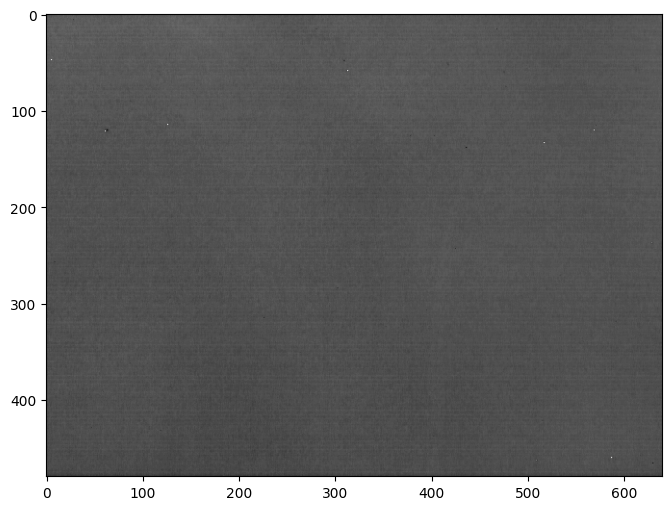

In [62]:
contrasted = [enhance_contrast_clahe(image) for image in corrected_scene_images]
denoised_contrasted =[non_local_means_denoise(cont)for cont in contrasted]
#display_images(contrasted)

KeyboardInterrupt: 

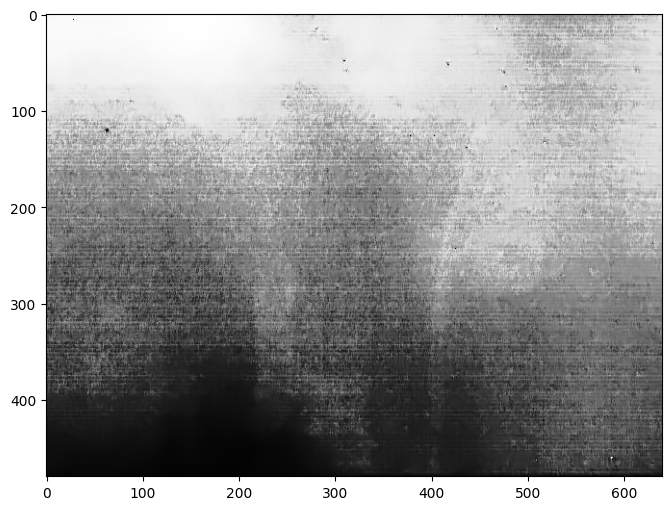

In [32]:
contrasted_2 = [enhance_contrast_histogram_equalization(image) for image in corrected_scene_images]
denoised_contrasted =[non_local_means_denoise(cont)for cont in contrasted_2]
display_images(denoised_contrasted)

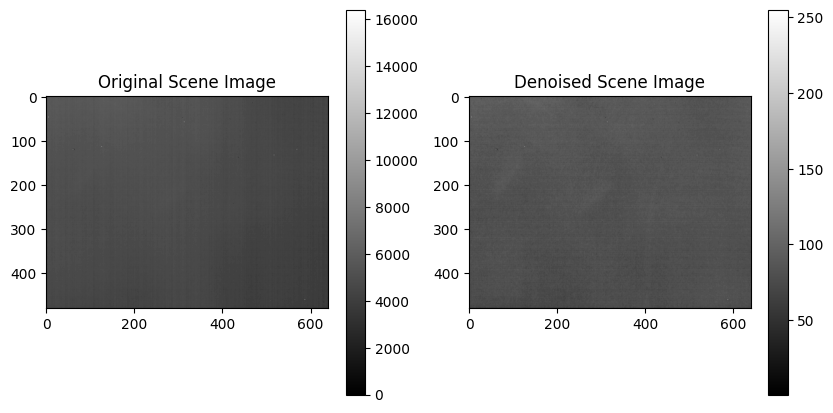

In [37]:
index = 15  # Index of the image to display

plt.figure(figsize=(10, 5))

# Original scene image
plt.subplot(1, 2, 1)
plt.title("Original Scene Image")
plt.imshow(scene_df['image'][index], cmap='gray')
plt.colorbar()

# Denoised scene image
plt.subplot(1, 2, 2)
plt.title("Denoised Scene Image")
plt.imshow(contrasted[index], cmap='gray')
plt.colorbar()

plt.show()

In [64]:
import cv2
import numpy as np

def save_video_from_images(images, output_filename, fps=60):
    """
    Save a sequence of images as a video.

    Parameters:
    images (list or array): List or array of images (each image should be a 2D or 3D NumPy array).
    output_filename (str): Output video filename (e.g., 'output.avi').
    fps (int): Frames per second for the video.
    """
    # Get the dimensions of the images
    height, width = images[0].shape[:2]

    # Define the codec and create VideoWriter object
    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    out = cv2.VideoWriter(output_filename, fourcc, fps, (width, height))

    for img in images:
        # Ensure image is in the correct format (uint8)
        img_uint8 = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')
        # If the image is grayscale, convert it to BGR
        if len(img_uint8.shape) == 2:
            img_uint8 = cv2.cvtColor(img_uint8, cv2.COLOR_GRAY2BGR)
        out.write(img_uint8)

    # Release everything when the job is finished
    out.release()

# Example usage:
# Assuming 'scene_images' is a list or array of images
scene_images = [np.random.rand(480, 640) for _ in range(100)]  # Example data, replace with actual images
output_filename = 'output3.avi'
save_video_from_images(contrasted, output_filename)
